In [57]:
import geopandas as gpd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap
import helper_400

%load_ext autoreload
%autoreload 2
helper_400.set_sns_style()

import plotting

%load_ext autoreload
%autoreload 2
hs_dict = plotting.get_hotspopt_dict()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Figure size 800x600 with 0 Axes>

In [58]:
df = pd.read_parquet("outputs/hotspots_per_fips_rolling.parquet")

In [59]:
df = df.groupby("GEOID").sum().reset_index()

In [68]:
hspts = plotting.get_hotspot_list()

In [61]:
df = df[['GEOID']+hspts]

In [62]:
df.to_parquet("outputs/agg_hotspots_per_fips_rolling.parquet")

In [30]:
gdf = gpd.read_file("data/esri/FIPSMapping.gdb")
gdf["FIPS_1"] = gdf.FIPS_1.astype(int)

data = gdf.merge(df, left_on="FIPS_1", right_on="GEOID")

<Axes: >

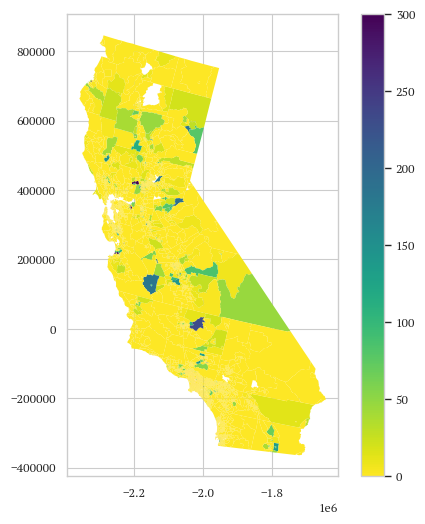

In [52]:
# Define a normalization from 0 to a maximum value
import matplotlib.colors as mcolors
norm = mcolors.Normalize(vmin=data['wfday'].min(), vmax=300)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
data.plot(
        column="wfday", ax=ax, legend=True, linewidth=0, cmap="viridis_r", missing_kwds={"color": "lightgrey"}, norm=norm
        )

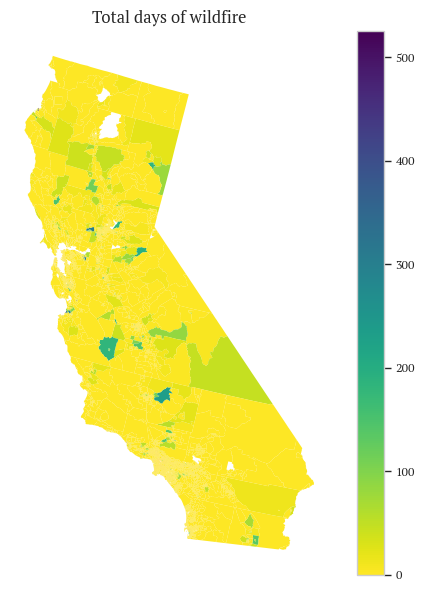

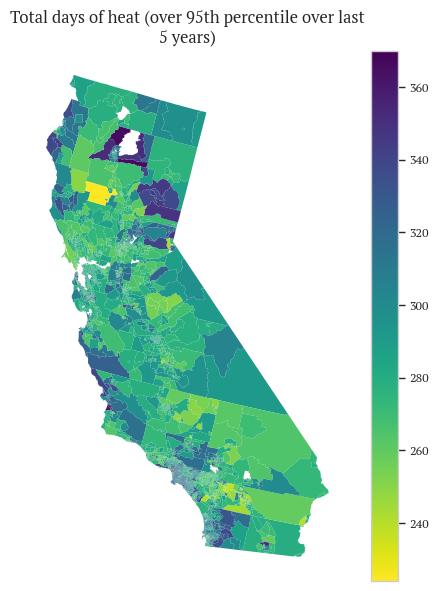

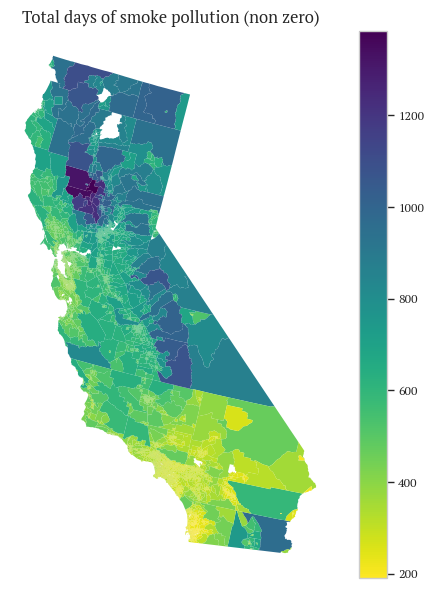

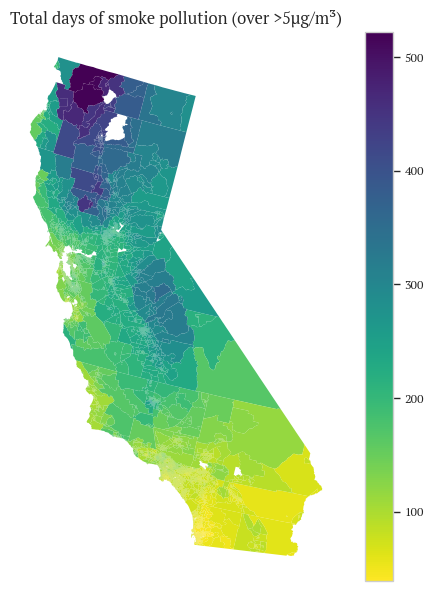

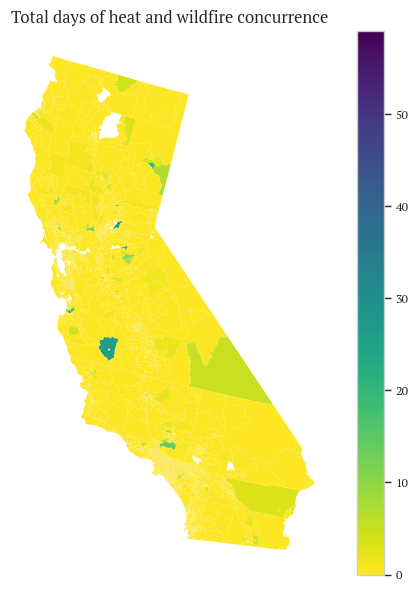

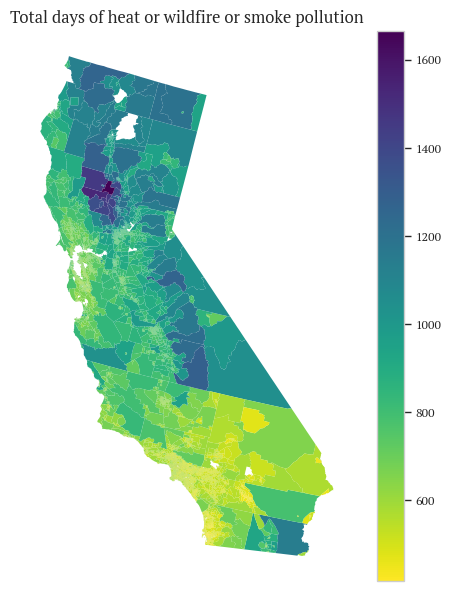

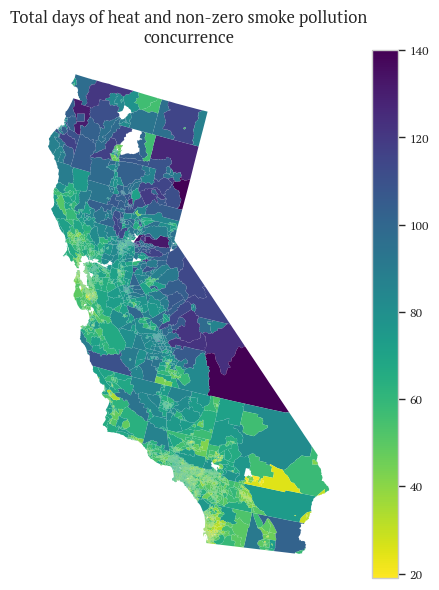

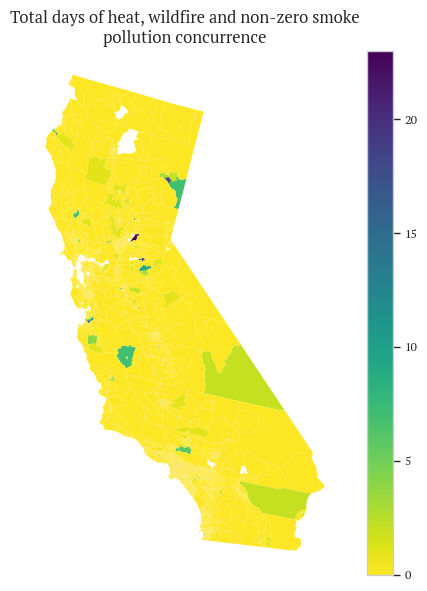

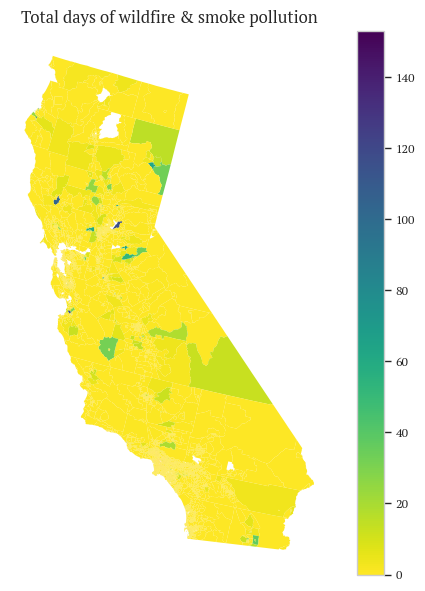

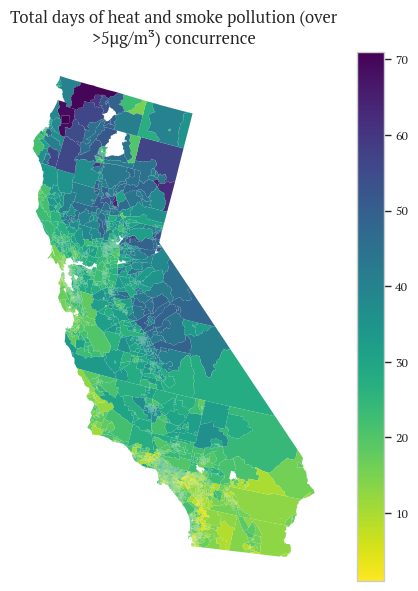

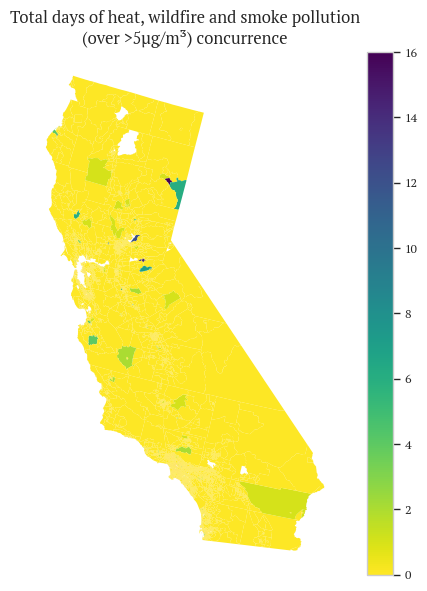

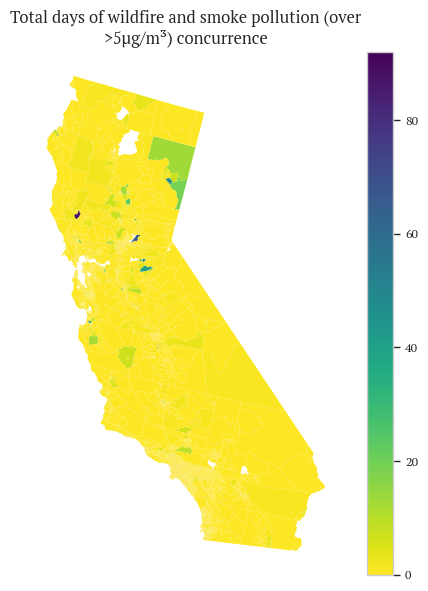

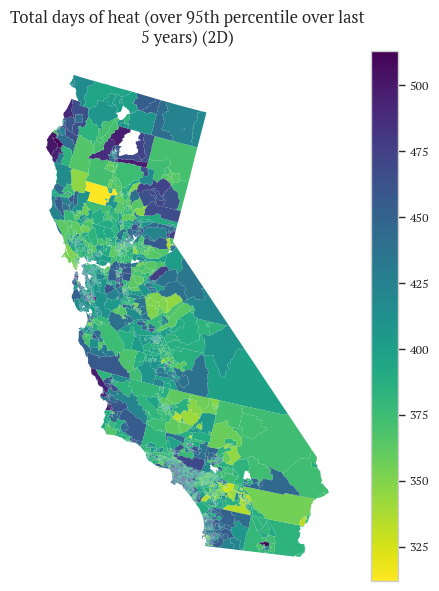

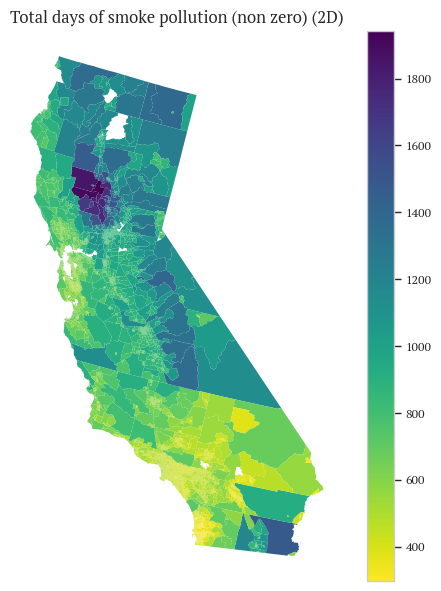

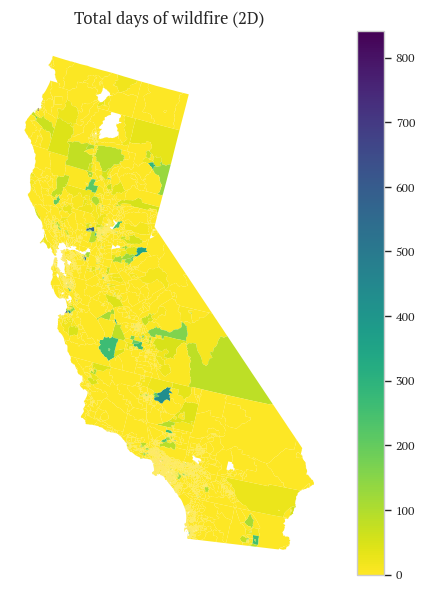

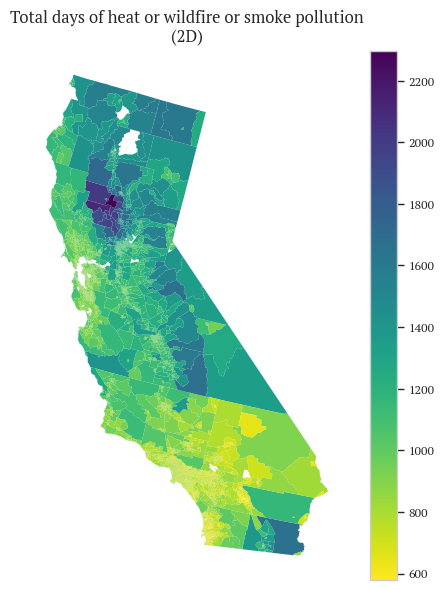

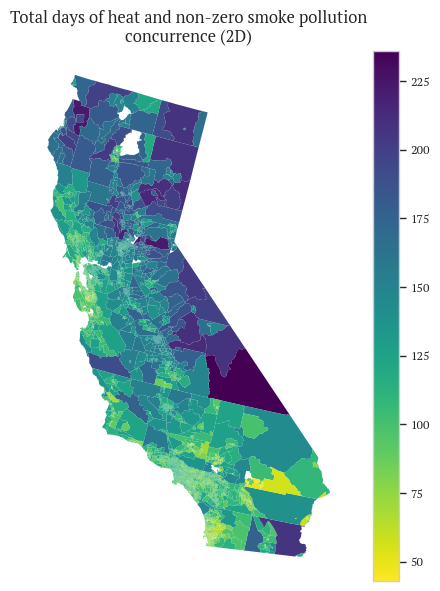

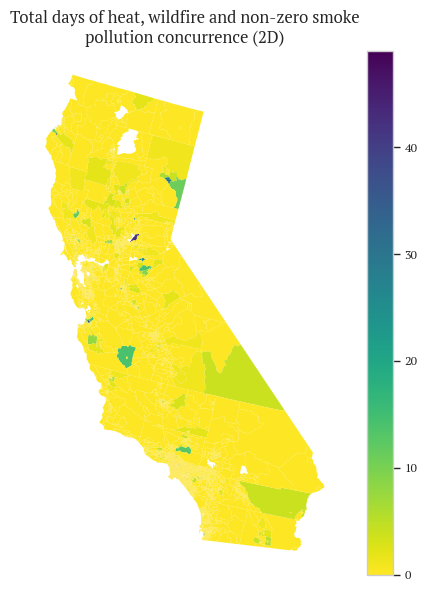

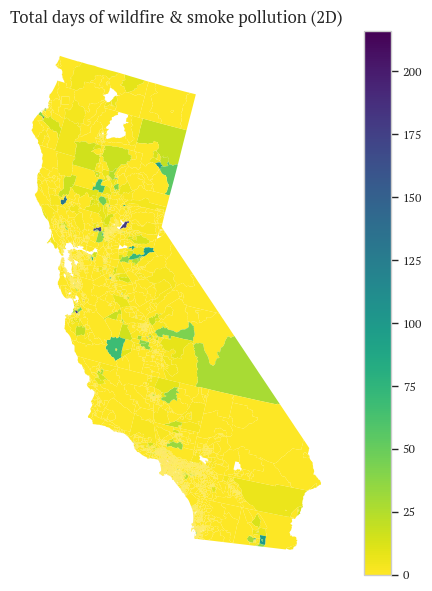

In [56]:
for x in hspts:
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    
    data.plot(
        column=x, ax=ax, legend=True, linewidth=0, cmap="viridis_r", missing_kwds={"color": "lightgrey"},
        )
    
    wrapped_title = textwrap.fill(hs_dict[x]["title_map"], 50)
    ax.set_title(wrapped_title, fontsize=12)
    ax.set_axis_off()
    
    plt.tight_layout()
    plt.savefig("figures/centract_hotspots_" + hs_dict[x]["title"] + ".png")
    plt.show()

## Add Vunerability Index

In [63]:
cols = [
    "STCNTY",
    "FIPS",
    "E_AFAM",
    "EP_AFAM",
    "E_TOTPOP",
    "EP_POV150",
    "EP_UNEMP",
    "EP_AGE65",
    "RPL_THEMES",
]
vind = pd.read_csv("data/California.csv", usecols=cols, dtype={"FIPS": str})
vind = vind[vind["RPL_THEMES"] > -1]

In [64]:
vind.FIPS = vind.FIPS.astype(int)

In [65]:
df = df.merge(vind, left_on="GEOID", right_on="FIPS")

In [67]:
df.to_csv("hotspot_vind_censustract.csv", index=False)

## Misc Plots

In [ ]:
census_tracts = gpd.read_file(
    "data/shapefiles/tl_2020_06_tract/tl_2020_06_tract.shp", dtype={"GEOID": int}
)
df = census_tracts.merge(vind, left_on="GEOID", right_on="FIPS")

In [ ]:
varsdict = {
    "EP_POV150": "Persons below 150% poverty estimate (%)",
    "EP_UNEMP": "Civilian (16+) unemployed estimate (%)",
    "EP_AGE65": "Persons aged 65 or older (%)",
    "EP_AFAM": "Black African-American",
}
pallete = {
    "EP_POV150": "pink_r",
    "EP_UNEMP": "summer_r",
    "EP_AGE65": "winter_r",
    "EP_AFAM": "cool",
}  # 'pink', 'spring', 'summer', 'autumn', 'winter', 'cool','Wistia'

/var/folders/b_/vlxgm9n10bz569rffzmcc5dc0000gn/T/ipykernel_36628/2880580489.py:12: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


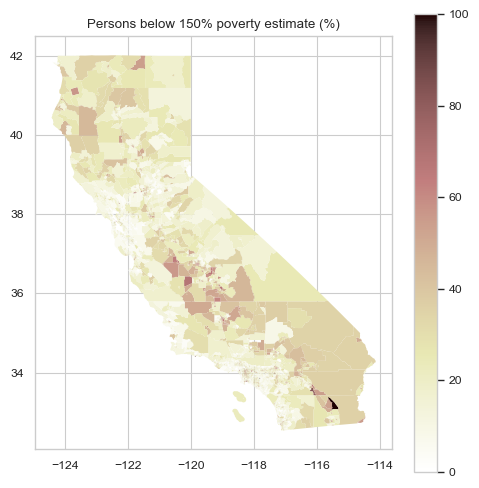

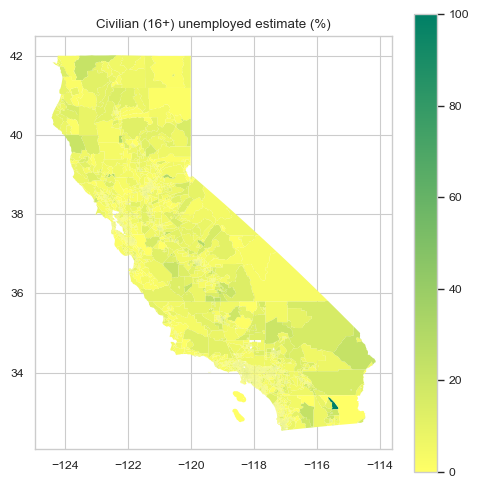

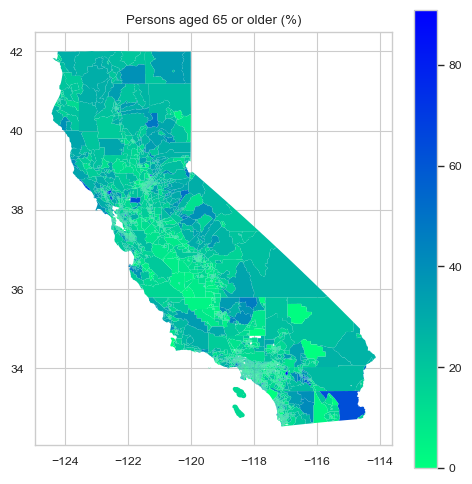

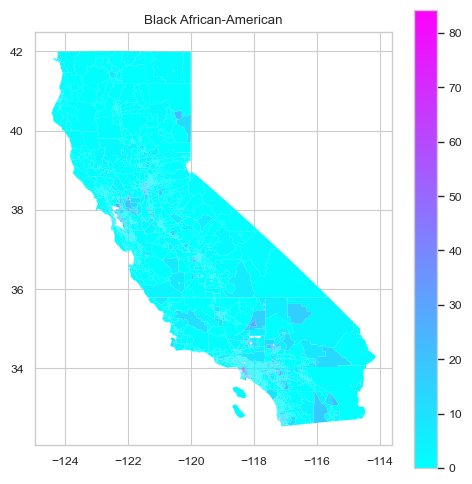

In [ ]:
for var in varsdict.keys():
    # Plot the map with a specified column and color palette
    ax = df.plot(
        column=var, cmap=pallete[var], figsize=(5, 5), linewidth=0, edgecolor="black"
    )

    # Add a color bar to the plot
    sm = plt.cm.ScalarMappable(
        cmap=pallete[var], norm=plt.Normalize(vmin=df[var].min(), vmax=df[var].max())
    )
    sm.var = []
    cbar = plt.colorbar(sm)
    plt.title(varsdict[var])
    plt.tight_layout()
    plt.savefig(varsdict[var])
    plt.show()